<a href="https://colab.research.google.com/github/geomyll33/Beautez/blob/master/EYATH__keras_multivariate_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [ ]:

dataset_train=pd.read_csv('/content/multivariateEYATH.csv')





In [ ]:
dataset_train

,timestamp,time,indication,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,relative_humidity
0,02-15-20,0:00,1.32,2.0,1.0,2.0,7.0,2.0,0.0,10.955556,8.983333,12.838889,7.039429,30.48,77.367019
1,02-15-20,0:15,1.36,2.0,1.0,2.0,7.0,2.0,0.0,10.955556,8.983333,12.838889,7.039429,30.48,77.367019
2,02-15-20,0:30,1.39,2.0,1.0,2.0,7.0,2.0,0.0,10.955556,8.983333,12.838889,7.039429,30.48,77.367019
3,02-15-20,0:45,1.43,2.0,1.0,2.0,7.0,2.0,0.0,10.955556,8.983333,12.838889,7.039429,30.48,77.367019
4,02-15-20,1:00,1.47,2.0,1.0,2.0,7.0,2.0,0.0,10.955556,8.983333,12.838889,7.039429,30.48,77.367019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dataset_train=dataset_train.dropna()

In [ ]:
dataset_train.columns

Index(['timestamp', 'time', 'indication',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'average_temperature_celsius', 'minimum_temperature_celsius',
       'maximum_temperature_celsius', 'rainfall_mm', 'snowfall_mm',
       'relative_humidity'],
      dtype='object')

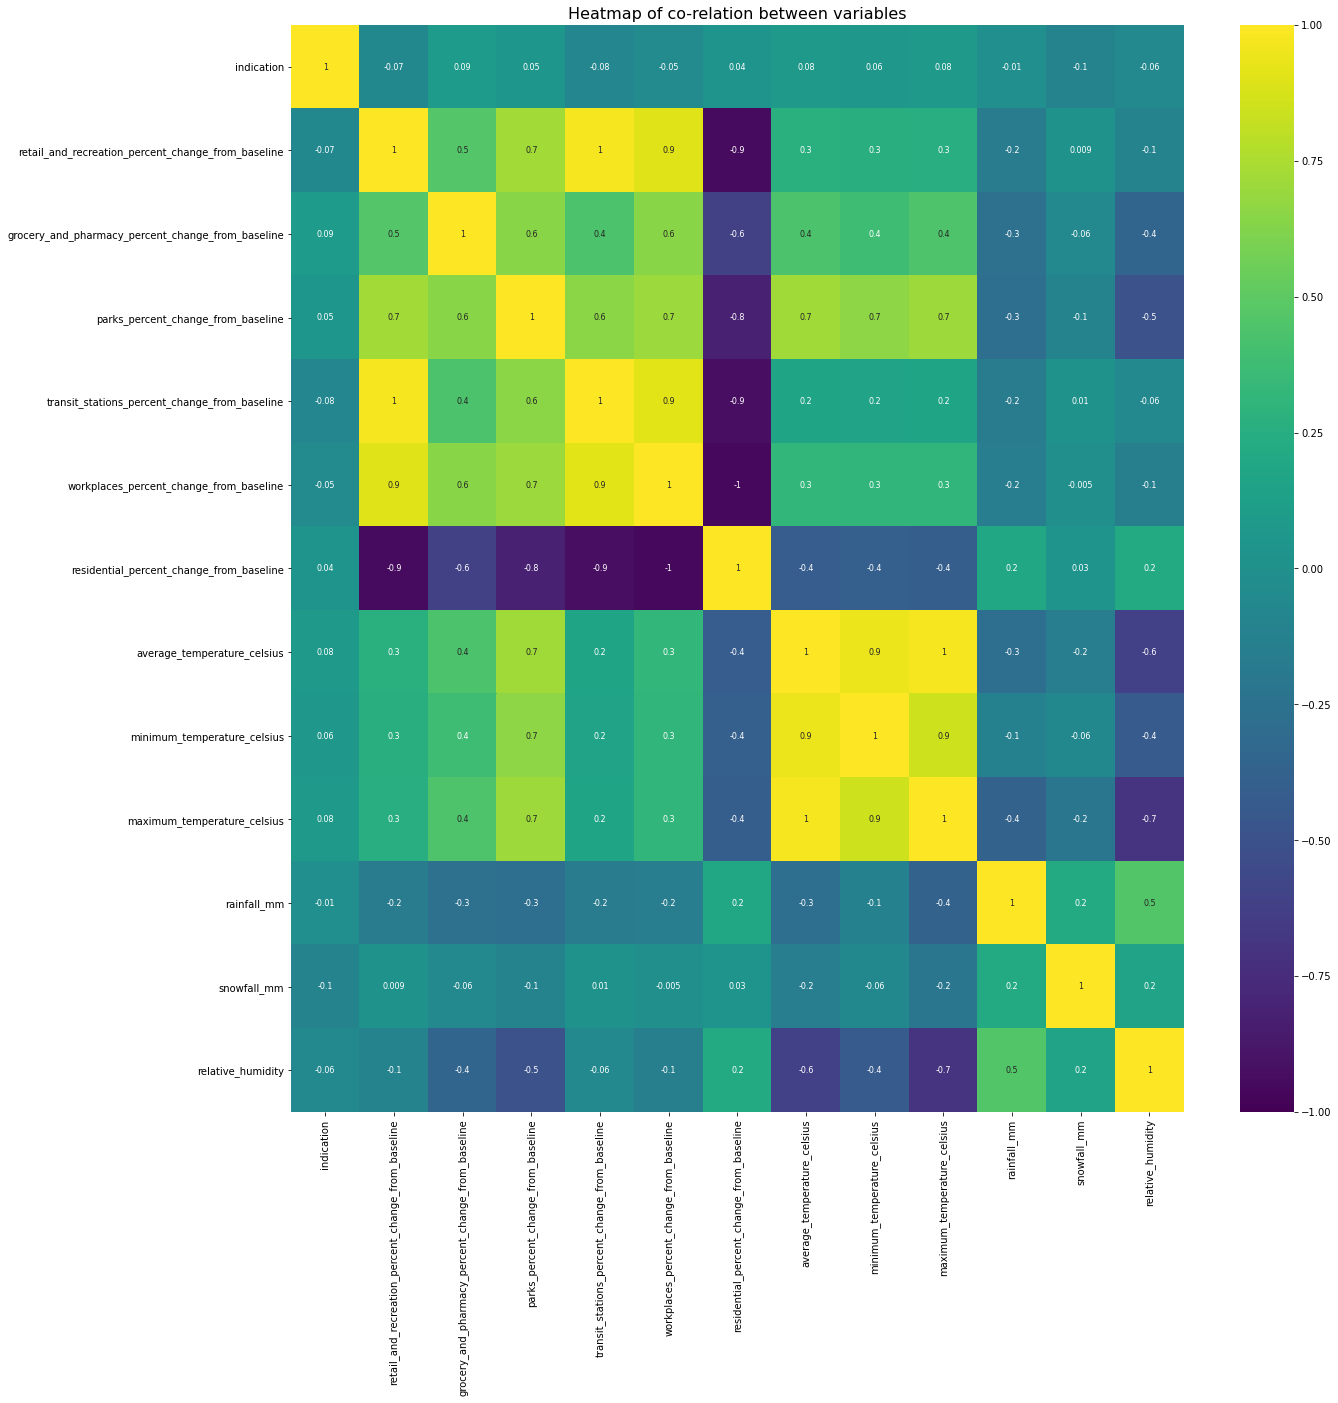

In [ ]:
import seaborn as sns
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(dataset_train.corr(),annot=True,fmt='.1g',vmin=-1, vmax=1, center= 0,annot_kws={"size":8},cmap='viridis')
plt.title('Heatmap of co-relation between variables',fontsize=16)
plt.show()

In [ ]:
dataset_train['timestamp'].dt.strftime('%m-%d-%y')

In [ ]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[2:15]

# Extract dates (will be used in visualization)

datelist_train = list(dataset_train['timestamp'])
datelist_train = [dt.datetime.strptime(date, '%m-%d-%y').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (12729, 15)
All timestamps == 12729
Featured selected: ['indication', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'average_temperature_celsius', 'minimum_temperature_celsius', 'maximum_temperature_celsius', 'rainfall_mm', 'snowfall_mm', 'relative_humidity']


In [ ]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (12729, 13).


array([[ 1.32    ,  2.      ,  1.      , ...,  7.039429, 30.48    ,
        77.367019],
       [ 1.36    ,  2.      ,  1.      , ...,  7.039429, 30.48    ,
        77.367019],
       [ 1.39    ,  2.      ,  1.      , ...,  7.039429, 30.48    ,
        77.367019],
       ...,
       [ 4.26    ,  5.      , 14.      , ...,  0.      ,  0.      ,
        43.045651],
       [ 3.7     ,  5.      , 14.      , ...,  0.      ,  0.      ,
        43.045651],
       [ 3.23    ,  5.      , 14.      , ...,  0.      ,  0.      ,
        43.045651]])

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-2.66088984],
       [-2.60901541],
       [-2.57010958],
       ...,
       [ 1.15188126],
       [ 0.42563915],
       [-0.18388549]])

In [ ]:

# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 12   # Number of days we want top predict into the future
n_past = 48     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (12670, 48, 12).
y_train shape == (12670, 1).


In [ ]:

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [ ]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
40/40 [==============================] - 10s 164ms/step - loss: 0.9606 - val_loss: 0.9176

Epoch 00001: val_loss improved from inf to 0.91763, saving model to weights.h5
Epoch 2/30
40/40 [==============================] - 5s 134ms/step - loss: 0.8222 - val_loss: 1.0724

Epoch 00002: val_loss did not improve from 0.91763
Epoch 3/30
40/40 [==============================] - 5s 134ms/step - loss: 0.7660 - val_loss: 0.8856

Epoch 00003: val_loss improved from 0.91763 to 0.88565, saving model to weights.h5
Epoch 4/30
40/40 [==============================] - 5s 132ms/step - loss: 0.7098 - val_loss: 0.9875

Epoch 00004: val_loss did not improve from 0.88565
Epoch 5/30
40/40 [==============================] - 5s 133ms/step - loss: 0.6467 - val_loss: 1.0780

Epoch 00005: val_loss did not improve from 0.88565
Epoch 6/30
40/40 [==============================] - 5s 134ms/step - loss: 0.6021 - val_loss: 0.9439

Epoch 00006: val_loss did not improve from 0.88565
Epoch 7/30
40/40 [=========

In [ ]:

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [ ]:

# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%y-%m-%d'), '%y-%m-%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN

,Open
2020-02-16,1.902810
2020-02-16,2.166550
2020-02-16,2.194550
2020-02-16,2.281461
2020-02-16,2.443569
...,...
2020-06-30,3.230065
2020-06-30,3.145124
2020-06-30,3.108638
2020-06-30,3.103757
